In [ ]:
# ls /home/joshua/jhonny/data/train/masks | grep sub-004

sub-004_rec-mial_dseg.nii.gz


In [44]:
import os
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader
import nibabel as nib
import numpy as np
from scipy.ndimage import zoom
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

# Force CPU usage and disable CUDA
os.environ['CUDA_VISIBLE_DEVICES'] = ''
torch.cuda.is_available = lambda: False

# -----------------------------
# ✅ Dataset
# -----------------------------
class MedicalImageDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, target_size=(64,64,64)):
        self.image_dir = Path(image_dir)
        self.mask_dir = Path(mask_dir)
        self.transform = transform
        self.target_size = target_size

        # List all images
        self.images = sorted(list(self.image_dir.glob("*.nii.gz")))

        # Filter out images without masks
        valid_images = []
        for img_path in self.images:
            mask_path = self.mask_dir / img_path.name.replace('_T2w', '_dseg')
            if mask_path.exists():
                valid_images.append(img_path)
        self.images = valid_images
        
        print(f"Found {len(self.images)} valid image-mask pairs")

    def __len__(self):
        return len(self.images)

    def _normalize(self, img):
        img_min = img.min()
        img_max = img.max()
        if img_max - img_min > 1e-8:
            return (img - img_min) / (img_max - img_min)
        return img

    def _resize_3d(self, img, target_size):
        factors = [t/s for t,s in zip(target_size, img.shape)]
        return zoom(img, factors, order=1)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        mask_path = self.mask_dir / img_path.name.replace('_T2w', '_dseg')

        img = nib.load(str(img_path)).get_fdata()
        mask = nib.load(str(mask_path)).get_fdata()

        # Resize
        if img.shape != self.target_size:
            img = self._resize_3d(img, self.target_size)
            mask = self._resize_3d(mask, self.target_size)

        # Normalize and binarize mask
        img = self._normalize(img)
        mask = (mask > 0).astype(np.float32)

        # Convert to tensors - ensure they're CPU tensors
        img = torch.tensor(img, dtype=torch.float32, device='cpu').unsqueeze(0)
        mask = torch.tensor(mask, dtype=torch.float32, device='cpu').unsqueeze(0)

        if self.transform:
            img, mask = self.transform(img, mask)

        return img, mask

# -----------------------------
# ✅ 3D U-Net
# -----------------------------
class UNet3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, init_features=8):
        super(UNet3D, self).__init__()
        features = init_features
        self.encoder1 = self._block(in_channels, features)
        self.pool1 = nn.MaxPool3d(2)
        self.encoder2 = self._block(features, features*2)
        self.pool2 = nn.MaxPool3d(2)
        self.encoder3 = self._block(features*2, features*4)
        self.pool3 = nn.MaxPool3d(2)
        self.encoder4 = self._block(features*4, features*8)
        self.pool4 = nn.MaxPool3d(2)

        self.bottleneck = self._block(features*8, features*16)

        self.upconv4 = nn.ConvTranspose3d(features*16, features*8, 2, stride=2)
        self.decoder4 = self._block(features*16, features*8)
        self.upconv3 = nn.ConvTranspose3d(features*8, features*4, 2, stride=2)
        self.decoder3 = self._block(features*8, features*4)
        self.upconv2 = nn.ConvTranspose3d(features*4, features*2, 2, stride=2)
        self.decoder2 = self._block(features*4, features*2)
        self.upconv1 = nn.ConvTranspose3d(features*2, features, 2, stride=2)
        self.decoder1 = self._block(features*2, features)

        self.conv = nn.Conv3d(features, out_channels, 1)

    def _block(self, in_channels, features):
        return nn.Sequential(
            nn.Conv3d(in_channels, features, 3, padding=1, bias=False),
            nn.BatchNorm3d(features),
            nn.ReLU(inplace=True),
            nn.Conv3d(features, features, 3, padding=1, bias=False),
            nn.BatchNorm3d(features),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))
        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return torch.sigmoid(self.conv(dec1))

# -----------------------------
# ✅ Dice + BCE Loss
# -----------------------------
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        pred = pred.contiguous().view(-1)
        target = target.contiguous().view(-1)
        intersection = (pred * target).sum()
        dice = (2.*intersection + self.smooth)/(pred.sum() + target.sum() + self.smooth)
        return 1 - dice

class DiceBCELoss(nn.Module):
    def __init__(self, weight_dice=0.5, weight_bce=0.5):
        super(DiceBCELoss, self).__init__()
        self.dice = DiceLoss()
        self.bce = nn.BCELoss()
        self.weight_dice = weight_dice
        self.weight_bce = weight_bce

    def forward(self, pred, target):
        return self.weight_dice*self.dice(pred, target) + self.weight_bce*self.bce(pred, target)

def dice_coefficient(pred, target, threshold=0.5):
    pred = (pred > threshold).float()
    target = target.float()
    intersection = (pred * target).sum()
    return (2.*intersection)/(pred.sum() + target.sum() + 1e-8)

# -----------------------------
# ✅ Training and validation
# -----------------------------
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    epoch_loss = 0
    epoch_dice = 0
    
    for images, masks in tqdm(loader, desc="Training"):
        # Ensure tensors are on the correct device
        images = images.to(device, non_blocking=False)
        masks = masks.to(device, non_blocking=False)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        with torch.no_grad():
            epoch_dice += dice_coefficient(outputs, masks).item()
            
    return epoch_loss/len(loader), epoch_dice/len(loader)

def validate(model, loader, criterion, device):
    model.eval()
    epoch_loss = 0
    epoch_dice = 0
    
    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Validation"):
            images = images.to(device, non_blocking=False)
            masks = masks.to(device, non_blocking=False)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            epoch_loss += loss.item()
            epoch_dice += dice_coefficient(outputs, masks).item()
            
    return epoch_loss/len(loader), epoch_dice/len(loader)

# -----------------------------
# ✅ Full training loop
# -----------------------------
def train_unet(train_image_dir, train_mask_dir, val_image_dir, val_mask_dir,
               num_epochs=50, batch_size=1, learning_rate=1e-4, device='cpu'):

    # Force CPU device
    device = torch.device('cpu')
    print(f"Using device: {device}")
    print(f"CUDA available: {torch.cuda.is_available()}")

    train_dataset = MedicalImageDataset(train_image_dir, train_mask_dir, target_size=(64,64,64))
    val_dataset = MedicalImageDataset(val_image_dir, val_mask_dir, target_size=(64,64,64))

    if len(train_dataset) == 0:
        raise ValueError("No training samples found! Check your data paths.")
    if len(val_dataset) == 0:
        raise ValueError("No validation samples found! Check your data paths.")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                             num_workers=0, pin_memory=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, 
                           num_workers=0, pin_memory=False)

    model = UNet3D(in_channels=1, out_channels=1, init_features=8)
    model = model.to(device)
    model.train()
    
    criterion = DiceBCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

    best_val_dice = 0
    train_losses, val_losses = [], []
    train_dices, val_dices = [], []

    for epoch in range(num_epochs):
        print(f"\n{'='*50}")
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"{'='*50}")
        
        train_loss, train_dice = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_dice = validate(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_dices.append(train_dice)
        val_dices.append(val_dice)

        print(f"\nResults:")
        print(f"  Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}")
        print(f"  Val Loss:   {val_loss:.4f}, Val Dice:   {val_dice:.4f}")

        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        print(f"  Learning Rate: {current_lr:.2e}")

        if val_dice > best_val_dice:
            best_val_dice = val_dice
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_dice': val_dice,
                'train_dice': train_dice,
                'val_loss': val_loss
            }, 'best_unet_model.pth')
            print(f"  ✓ Saved best model with Val Dice: {val_dice:.4f}")

    # Plot training curves
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(train_losses, label='Train Loss', marker='o', markersize=3)
    plt.plot(val_losses, label='Val Loss', marker='s', markersize=3)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curves')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1,2,2)
    plt.plot(train_dices, label='Train Dice', marker='o', markersize=3)
    plt.plot(val_dices, label='Val Dice', marker='s', markersize=3)
    plt.xlabel('Epoch')
    plt.ylabel('Dice Coefficient')
    plt.legend()
    plt.title('Dice Coefficient')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_curves.png', dpi=150)
    print(f"\nTraining curves saved to 'training_curves.png'")
    plt.show()

    print(f"\n{'='*50}")
    print(f"Training Complete!")
    print(f"Best Validation Dice: {best_val_dice:.4f}")
    print(f"{'='*50}")

    return model

Using device: cpu
CUDA available: False
Found 64 valid image-mask pairs
Found 16 valid image-mask pairs

Epoch 1/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.25it/s]



Results:
  Train Loss: 0.7348, Train Dice: 0.3082
  Val Loss:   0.7322, Val Dice:   0.4248
  Learning Rate: 1.00e-04
  ✓ Saved best model with Val Dice: 0.4248

Epoch 2/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]



Results:
  Train Loss: 0.6674, Train Dice: 0.4292
  Val Loss:   0.6893, Val Dice:   0.3272
  Learning Rate: 1.00e-04

Epoch 3/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.01it/s]



Results:
  Train Loss: 0.6503, Train Dice: 0.3498
  Val Loss:   0.6619, Val Dice:   0.3119
  Learning Rate: 1.00e-04

Epoch 4/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.05it/s]



Results:
  Train Loss: 0.6410, Train Dice: 0.3446
  Val Loss:   0.6757, Val Dice:   0.2719
  Learning Rate: 1.00e-04

Epoch 5/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.04it/s]



Results:
  Train Loss: 0.6336, Train Dice: 0.3545
  Val Loss:   0.6620, Val Dice:   0.2979
  Learning Rate: 1.00e-04

Epoch 6/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]



Results:
  Train Loss: 0.6259, Train Dice: 0.3855
  Val Loss:   0.6538, Val Dice:   0.3311
  Learning Rate: 1.00e-04

Epoch 7/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.02it/s]



Results:
  Train Loss: 0.6183, Train Dice: 0.4055
  Val Loss:   0.6504, Val Dice:   0.3392
  Learning Rate: 1.00e-04

Epoch 8/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.17it/s]



Results:
  Train Loss: 0.6108, Train Dice: 0.4486
  Val Loss:   0.6421, Val Dice:   0.4578
  Learning Rate: 1.00e-04
  ✓ Saved best model with Val Dice: 0.4578

Epoch 9/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.02s/it]



Results:
  Train Loss: 0.6005, Train Dice: 0.6086
  Val Loss:   0.6287, Val Dice:   0.6327
  Learning Rate: 1.00e-04
  ✓ Saved best model with Val Dice: 0.6327

Epoch 10/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.29it/s]



Results:
  Train Loss: 0.5891, Train Dice: 0.7573
  Val Loss:   0.6183, Val Dice:   0.7117
  Learning Rate: 1.00e-04
  ✓ Saved best model with Val Dice: 0.7117

Epoch 11/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]



Results:
  Train Loss: 0.5815, Train Dice: 0.8097
  Val Loss:   0.6084, Val Dice:   0.7519
  Learning Rate: 1.00e-04
  ✓ Saved best model with Val Dice: 0.7519

Epoch 12/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.25it/s]



Results:
  Train Loss: 0.5749, Train Dice: 0.8298
  Val Loss:   0.6016, Val Dice:   0.7590
  Learning Rate: 1.00e-04
  ✓ Saved best model with Val Dice: 0.7590

Epoch 13/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]



Results:
  Train Loss: 0.5673, Train Dice: 0.8487
  Val Loss:   0.5954, Val Dice:   0.8117
  Learning Rate: 1.00e-04
  ✓ Saved best model with Val Dice: 0.8117

Epoch 14/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.02s/it]



Results:
  Train Loss: 0.5599, Train Dice: 0.8655
  Val Loss:   0.5908, Val Dice:   0.8059
  Learning Rate: 1.00e-04

Epoch 15/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.37it/s]



Results:
  Train Loss: 0.5528, Train Dice: 0.8794
  Val Loss:   0.5821, Val Dice:   0.8938
  Learning Rate: 1.00e-04
  ✓ Saved best model with Val Dice: 0.8938

Epoch 16/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]



Results:
  Train Loss: 0.5457, Train Dice: 0.8897
  Val Loss:   0.5842, Val Dice:   0.8295
  Learning Rate: 1.00e-04

Epoch 17/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]



Results:
  Train Loss: 0.5392, Train Dice: 0.8997
  Val Loss:   0.5682, Val Dice:   0.8936
  Learning Rate: 1.00e-04

Epoch 18/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]



Results:
  Train Loss: 0.5324, Train Dice: 0.9098
  Val Loss:   0.5724, Val Dice:   0.8246
  Learning Rate: 1.00e-04

Epoch 19/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.10it/s]



Results:
  Train Loss: 0.5250, Train Dice: 0.9151
  Val Loss:   0.5573, Val Dice:   0.8867
  Learning Rate: 1.00e-04

Epoch 20/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.28it/s]



Results:
  Train Loss: 0.5178, Train Dice: 0.9255
  Val Loss:   0.5455, Val Dice:   0.8913
  Learning Rate: 1.00e-04

Epoch 21/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]



Results:
  Train Loss: 0.5113, Train Dice: 0.9302
  Val Loss:   0.5457, Val Dice:   0.8705
  Learning Rate: 1.00e-04

Epoch 22/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]



Results:
  Train Loss: 0.5044, Train Dice: 0.9357
  Val Loss:   0.5452, Val Dice:   0.8575
  Learning Rate: 1.00e-04

Epoch 23/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.02s/it]



Results:
  Train Loss: 0.4978, Train Dice: 0.9379
  Val Loss:   0.5322, Val Dice:   0.8797
  Learning Rate: 1.00e-04

Epoch 24/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]



Results:
  Train Loss: 0.4916, Train Dice: 0.9397
  Val Loss:   0.5291, Val Dice:   0.8702
  Learning Rate: 1.00e-04

Epoch 25/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.02it/s]



Results:
  Train Loss: 0.4847, Train Dice: 0.9450
  Val Loss:   0.5177, Val Dice:   0.9018
  Learning Rate: 1.00e-04
  ✓ Saved best model with Val Dice: 0.9018

Epoch 26/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]



Results:
  Train Loss: 0.4779, Train Dice: 0.9473
  Val Loss:   0.5084, Val Dice:   0.9206
  Learning Rate: 1.00e-04
  ✓ Saved best model with Val Dice: 0.9206

Epoch 27/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]



Results:
  Train Loss: 0.4713, Train Dice: 0.9504
  Val Loss:   0.5108, Val Dice:   0.8921
  Learning Rate: 1.00e-04

Epoch 28/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.00s/it]



Results:
  Train Loss: 0.4646, Train Dice: 0.9532
  Val Loss:   0.5002, Val Dice:   0.8992
  Learning Rate: 1.00e-04

Epoch 29/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.00s/it]



Results:
  Train Loss: 0.4581, Train Dice: 0.9551
  Val Loss:   0.4918, Val Dice:   0.9033
  Learning Rate: 1.00e-04

Epoch 30/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]



Results:
  Train Loss: 0.4520, Train Dice: 0.9546
  Val Loss:   0.4915, Val Dice:   0.9043
  Learning Rate: 1.00e-04

Epoch 31/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.02s/it]



Results:
  Train Loss: 0.4456, Train Dice: 0.9566
  Val Loss:   0.4783, Val Dice:   0.9092
  Learning Rate: 1.00e-04

Epoch 32/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]



Results:
  Train Loss: 0.4389, Train Dice: 0.9585
  Val Loss:   0.4756, Val Dice:   0.9033
  Learning Rate: 1.00e-04

Epoch 33/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.00s/it]



Results:
  Train Loss: 0.4325, Train Dice: 0.9595
  Val Loss:   0.4770, Val Dice:   0.9068
  Learning Rate: 1.00e-04

Epoch 34/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]



Results:
  Train Loss: 0.4264, Train Dice: 0.9600
  Val Loss:   0.4609, Val Dice:   0.9014
  Learning Rate: 1.00e-04

Epoch 35/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.02s/it]



Results:
  Train Loss: 0.4199, Train Dice: 0.9617
  Val Loss:   0.4629, Val Dice:   0.9048
  Learning Rate: 1.00e-04

Epoch 36/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.02s/it]



Results:
  Train Loss: 0.4138, Train Dice: 0.9628
  Val Loss:   0.4474, Val Dice:   0.9050
  Learning Rate: 1.00e-04

Epoch 37/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]



Results:
  Train Loss: 0.4075, Train Dice: 0.9627
  Val Loss:   0.4550, Val Dice:   0.8790
  Learning Rate: 1.00e-04

Epoch 38/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]



Results:
  Train Loss: 0.4014, Train Dice: 0.9627
  Val Loss:   0.4324, Val Dice:   0.9237
  Learning Rate: 1.00e-04
  ✓ Saved best model with Val Dice: 0.9237

Epoch 39/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.00s/it]



Results:
  Train Loss: 0.3948, Train Dice: 0.9644
  Val Loss:   0.4359, Val Dice:   0.9074
  Learning Rate: 1.00e-04

Epoch 40/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.00it/s]



Results:
  Train Loss: 0.3881, Train Dice: 0.9655
  Val Loss:   0.4242, Val Dice:   0.9102
  Learning Rate: 1.00e-04

Epoch 41/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]



Results:
  Train Loss: 0.3812, Train Dice: 0.9676
  Val Loss:   0.4145, Val Dice:   0.9201
  Learning Rate: 1.00e-04

Epoch 42/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.01it/s]



Results:
  Train Loss: 0.3750, Train Dice: 0.9678
  Val Loss:   0.4196, Val Dice:   0.9092
  Learning Rate: 1.00e-04

Epoch 43/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.16it/s]



Results:
  Train Loss: 0.3684, Train Dice: 0.9690
  Val Loss:   0.4190, Val Dice:   0.9028
  Learning Rate: 1.00e-04

Epoch 44/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.07it/s]



Results:
  Train Loss: 0.3630, Train Dice: 0.9640
  Val Loss:   0.4107, Val Dice:   0.8848
  Learning Rate: 1.00e-04

Epoch 45/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.25it/s]



Results:
  Train Loss: 0.3568, Train Dice: 0.9655
  Val Loss:   0.3893, Val Dice:   0.9102
  Learning Rate: 1.00e-04

Epoch 46/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.26it/s]



Results:
  Train Loss: 0.3499, Train Dice: 0.9683
  Val Loss:   0.3964, Val Dice:   0.9183
  Learning Rate: 1.00e-04

Epoch 47/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.03s/it]



Results:
  Train Loss: 0.3435, Train Dice: 0.9690
  Val Loss:   0.3826, Val Dice:   0.9043
  Learning Rate: 1.00e-04

Epoch 48/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.25it/s]



Results:
  Train Loss: 0.3375, Train Dice: 0.9692
  Val Loss:   0.3804, Val Dice:   0.9178
  Learning Rate: 1.00e-04

Epoch 49/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.06it/s]



Results:
  Train Loss: 0.3314, Train Dice: 0.9696
  Val Loss:   0.3726, Val Dice:   0.9046
  Learning Rate: 1.00e-04

Epoch 50/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.02s/it]



Results:
  Train Loss: 0.3258, Train Dice: 0.9688
  Val Loss:   0.3738, Val Dice:   0.8842
  Learning Rate: 1.00e-04

Training curves saved to 'training_curves.png'


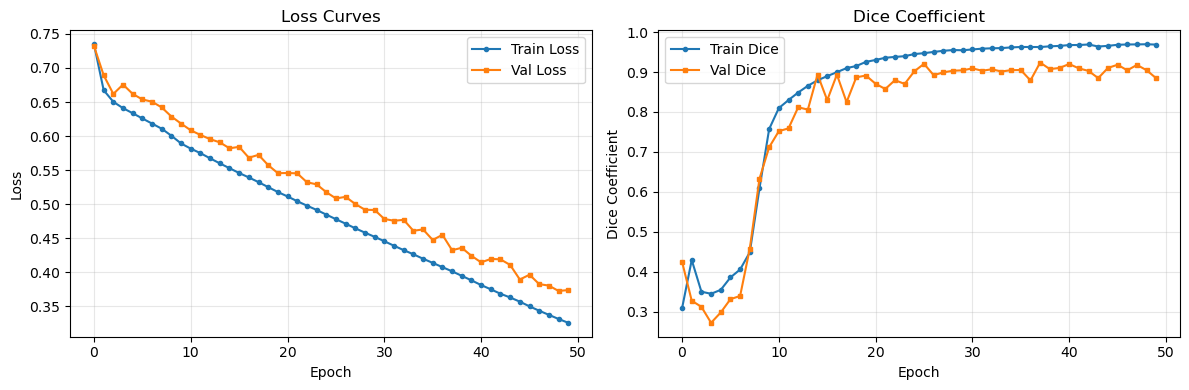


Training Complete!
Best Validation Dice: 0.9237


In [45]:
cwd = os.getcwd()
train_image_dir = Path(f"{cwd}/data/train/images")
train_mask_dir  = Path(f"{cwd}/data/train/masks")
val_image_dir   = Path(f"{cwd}/data/val/images")
val_mask_dir    = Path(f"{cwd}/data/val/masks")

    # Verify paths exist
for path, name in [(train_image_dir, "train images"), 
                       (train_mask_dir, "train masks"),
                       (val_image_dir, "val images"), 
                       (val_mask_dir, "val masks")]:
    if not path.exists():
        print(f"Warning: {name} directory does not exist: {path}")

model = train_unet(
        train_image_dir=train_image_dir,
        train_mask_dir=train_mask_dir,
        val_image_dir=val_image_dir,
        val_mask_dir=val_mask_dir,
        num_epochs=50,
        batch_size=1,
        learning_rate=1e-4,
        device='cpu'
    )